# DotA 2: Patch 7.33
## What has changed in the economy?

![](https://cdn.cloudflare.steamstatic.com/steamcommunity/public/images/clans/3703047/a85289fa2be0854a08a57f8c76d927c1cd38e385.jpg "Patch 7.33")

DotA 2's newest patch came with an overhaul of long awaited changes. Some of the notable ones include an increased map size (up to 40% from before!), change in Roshan's location and the addition of new objectives. As a result, the game's economy has also been affected.

Some of the changes that impact the gold available on the map were:

- New jungle camps added (12 in total);
- Lane creeps providing less gold as the game progresses;
- The addition of Tormentors include up to two Aghanim's Shards each 10 minutes (starting at the 20 minute mark);

<!-- - Rescaling of gold distributed in assists; -->

This notebook will provide an overview for how much the game has changed economy-wise. We'll begin by estimating how much gold is available from different sources, namely: GPM (passive gold per minute), Lane creeps, Neutral creeps, Bounty runes and Tormentors.

The information for this project came directly from [DotA 2's Wiki](https://dota2.fandom.com/wiki/Gold), and the [official 7.33 patch notes](https://www.dota2.com/patches/7.33). 

The Python implementation uses mainly `pandas` and `numpy` libraries, and `matplotlib` for plotting graphs.

## Creating our data

In [1]:
# Modules used in this project and some default configurations
import pandas as pd
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.set_option("display.max_columns", 100)

### GPM

Every player receives some periodic gold over the time. This starts with 90g per minute, increasing gradualy over time, according to the following table:

|Time in Game |	GPM From This Time Onward |
|-------------|---------------------------|
| 0:00        |        90.0 Gold          |
| 12:00       |        94.8 Gold          |
| 30:00 	  |        99.8 Gold          |
| 45:00 	  |       105.5 Gold          |
| 62:00 	  |       112.8 Gold          |
| 87:00 	  |       120.5 Gold          |
| 112:00 	  |       129.0 Gold          |
| 140:00 	  |       139.0 Gold          |
| 175:00 	  |       150.5 Gold          |

In [2]:
# Creating gpm data frame
gpm = pd.DataFrame(np.arange(0, 250, .5), columns = ['minute'])

# Periodic gold
def periodic_gold(minute):
    if minute < 12:
        return 90
    elif minute < 30:
        return 94.8
    elif minute < 45:
        return 99.8
    elif minute < 62:
        return 105.5
    elif minute < 87:
        return 112.8
    elif minute < 112:
        return 129
    elif minute < 140:
        return 139
    else:
        return 150.5
    
gpm['gpm'] = gpm.minute.apply(periodic_gold)
gpm = gpm.set_index('minute')

# Dividing gpm by periods of 30s and multipling by number of heroes of a team
gpm['total_periodic_gold'] = gpm.gpm / 2 * 5 
# Cumulative sum of gold
gpm['cum_periodic_gold'] = gpm.loc[:, 'total_periodic_gold'].cumsum()

### Lane creeps

Lane creeps spawn in groups, called _waves_, every 30 seconds. There are mainly four types of creeps: melee, ranged, flagbearers and siege creeps. Each have their Mega and Super versions, but we will be not looking in to it since they only appear after some buildings are destroyed. 

Speaking of which, buildings (towers and barracks) were also not included in this analysis, since the focus of this project is on events that happen on a timely manner.

The first waves are made of 3 melee creeps and 1 ranged creep. As the game progresses, not only the number of creeps will be increasing but the flagbearers and siege creeps are also included in a periodic basis.

- The melee creeps are the most numerous creeps in any given wave. They have more health but lower damage than ranged creeps. 

    ![](https://static.wikia.nocookie.net/dota2_gamepedia/images/e/e7/Melee_Creep_Radiant_model.png/revision/latest/scale-to-width-down/250?cb=20160318190437 "Radiant melee creep") ![](https://static.wikia.nocookie.net/dota2_gamepedia/images/a/a9/Melee_Creep_Dire_model.png/revision/latest/scale-to-width-down/250?cb=20160318190431 "Dire melee creep")

- Ranged creeps, as the name suggest, can attack their targets from a distance. Also they do more damage to other creeps, but come with less health than melee creeps.

    ![](https://static.wikia.nocookie.net/dota2_gamepedia/images/0/0b/Ranged_Creep_Radiant_model.png/revision/latest/scale-to-width-down/250?cb=20160318190439 "Radiant ranged creep") ![](https://static.wikia.nocookie.net/dota2_gamepedia/images/3/3f/Ranged_Creep_Dire_model.png/revision/latest/scale-to-width-down/250?cb=20160318190433 "Dire ranged creep")

- Flagbearers start appearing every minute from the 2:00 minute wave and onwards, replacing one of the melee creeps in the wave. In addition to having a unique aura that increases the health regen of nearby allies, flagbearer's also grants bonus gold for nearby heroes when killed. They have the same appearance as a melee creep, but they carry a flag.

    ![](https://static.wikia.nocookie.net/dota2_gamepedia/images/9/93/Inspiration_Aura_%28Flagbearer_Creep%29_icon.png/revision/latest/scale-to-width-down/128?cb=20220824110455 "Flagbearer creep icon")

- Siege creeps, often called catapults, appear more sparsely over the match, spawning every 5 minutes starting from the 5:00 minute mark. They have higher health and higher magic resistance than other types of creeps, and their main trait is the ability to deal more damage to structures, often prioritizing them over heroes and other creeps.

    ![](https://static.wikia.nocookie.net/dota2_gamepedia/images/5/56/Siege_Creep_Radiant_model.png/revision/latest/scale-to-width-down/250?cb=20160318190445 "Radiant siege creep") ![](https://static.wikia.nocookie.net/dota2_gamepedia/images/6/6a/Siege_Creep_Dire_model.png/revision/latest/scale-to-width-down/250?cb=20160318190437 "Dire siege creep")

Each creep gives gold when last-hitted, the amount varying on a specifc range depending on the type of creep. To make the analysis in this project easier, we will be focusing on only the average gold given by each type.

| Type | Average gold |
| ---- | ------------ |
| Melee | 37 |
| Ranged | 48 |
| Flagbearer | 37 + 46 (bonus) |
| Siege | 66 |

The first change we will be discussing from this new patch is that lane creeps had their gold bounties upgraded trough the match.

From the Gameplay Update of Patch 7.33:

---
_Changed Gold bounty for lane creeps:_

> Melee Creep Gold bounty increase per upgrade decreased from 1 to 0

> Super Melee Creep gold bounty increase per upgrade decreased from 1.5 to 0
    
> Ranged Creep Gold bounty increase per upgrade decreased from 6 to 3
    
> Super Ranged Creep Gold bounty increase per upgrade decreased from 6 to 3

---

Later on we will be going to look how much this change affects the gold per wave.

The following codeblocks generate the amount of creeps and total gold given by the Lane creeps.

In [3]:
# Creeps gold
melee_base_gold = 37
ranged_base_gold = 48
flagbearer_base_gold = 37 + 46
siege_base_gold = 66

# Creeps gold gained from each upgrade
melee_upgrade_gold_old = 1
melee_upgrade_gold_new = 0
ranged_upgrade_gold_old = 6
ranged_upgrade_gold_new = 3

# Time when creeps upgrade
period_to_upgrade = 7.5
creeps_upgrade_gold_minutes = list(np.arange(period_to_upgrade, 
                                             225 + period_to_upgrade, 
                                             period_to_upgrade))

# Help function to upgrade gold from creeps
def gold_of_creeps(base_gold, upgrade_gold, creeps_upgrade_minutes):
    creeps_gold = {minute: base_gold for minute in np.arange(0, 250, .5)}
    for minute in creeps_upgrade_minutes:
        creeps_gold = {time: (gold + upgrade_gold
                             if time >= minute 
                             else gold)
                             for time, gold 
                             in creeps_gold.items()}

    return creeps_gold

# Melee creeps had their gold increased by 1 in the old patch
melee_gold_old = gold_of_creeps(melee_base_gold, 
                                melee_upgrade_gold_old, 
                                creeps_upgrade_gold_minutes)

# Melee creeps had their gold increased by 6 in the old patch
ranged_gold_old = gold_of_creeps(ranged_base_gold, 
                                 ranged_upgrade_gold_old, 
                                 creeps_upgrade_gold_minutes)

# Melee creeps had their gold increased by 0 in the new patch
melee_gold_new = gold_of_creeps(melee_base_gold, 
                                melee_upgrade_gold_new, 
                                creeps_upgrade_gold_minutes)

# Melee creeps had their gold increased by 3 in the new patch
ranged_gold_new = gold_of_creeps(ranged_base_gold, 
                                 ranged_upgrade_gold_new, 
                                 creeps_upgrade_gold_minutes)

# Flagbearers and siege don't upgrade the gold given
flagbearer_gold = gold_of_creeps(flagbearer_base_gold, 0, [0])
siege_gold = gold_of_creeps(siege_base_gold, 0, [0])

# Creating data frame of golds by type of creep by minute
creeps_gold_old = (
    pd.DataFrame(
    {'melee_gold': melee_gold_old, 
     'ranged_gold': ranged_gold_old, 
     'siege_gold': siege_gold, 
     'flagbearer_gold': flagbearer_gold,})
    .sort_index().reset_index().rename(columns = {'index': 'minute'})
    .set_index('minute')
)

creeps_gold_new = (
    pd.DataFrame(
    {'melee_gold': melee_gold_new, 
     'ranged_gold': ranged_gold_new, 
     'siege_gold': siege_gold, 
     'flagbearer_gold': flagbearer_gold,})
    .sort_index().reset_index().rename(columns = {'index': 'minute'})
    .set_index('minute')
)

In [4]:
# Times when creeps add in numbers
melee_add_num_minutes = [15, 30, 45]
siege_add_num_minutes = [35, ]
ranged_add_num_minutes = [40, ]

# Help function to add creeps in a period
def number_of_creeps(creeps_start, start, period, add_num_minutes):
    creeps_num = {minute: creeps_start for minute in np.arange(start, 250, period)}
    for minute in add_num_minutes:
        creeps_num = {time: (creeps + 1 
                             if time >= minute 
                             else creeps)
                             for time, creeps 
                             in creeps_num.items()}

    return creeps_num

# Number of creeps by minute
# Melee creeps start with 3 and spawn each wave
melee_num = number_of_creeps(3, 0, .5, melee_add_num_minutes)
# Ranged creeps start with 1 and spawn each wave
ranged_num = number_of_creeps(1, 0, .5, siege_add_num_minutes)
# Siege creeps start with 1 and spawn each 10th wave (5 min, 10 min, 15 min, ...)
siege_num = number_of_creeps(1, 5, 5, siege_add_num_minutes)
# Flagbearer creeps start spawning on the 2 min wave and every minute after 
flagbearer_num = number_of_creeps(0, 2, 1, [0])

# Data frame of creeps number by type and by minute
lanes_num = (
    pd.DataFrame(
    {'melee_num': melee_num, 
     'ranged_num': ranged_num, 
     'siege_num': siege_num, 
     'flagbearer_num': flagbearer_num, })
     .sort_index().fillna(0).reset_index()
     .rename(columns = {'index': 'minute'})
     .set_index('minute')
)

# Flagbearer creeps replace a random melee creep
lanes_num['melee_num'] = lanes_num['melee_num'] - lanes_num['flagbearer_num']


In [5]:
# Merging data
lanes_old = lanes_num.merge(creeps_gold_old, on = 'minute')

# Creating gold by type of creep
lanes_old['melee'] = lanes_old.melee_num * lanes_old.melee_gold
lanes_old['ranged'] = lanes_old.ranged_num * lanes_old.ranged_gold
lanes_old['siege'] = lanes_old.siege_num * lanes_old.siege_gold
lanes_old['flagbearer'] = lanes_old.flagbearer_num * lanes_old.flagbearer_gold
# Total column multiplied by 3 lanes
lanes_old['total_lane_gold'] = lanes_old.loc[:, ['melee', 'ranged', 'siege', 'flagbearer']].sum(axis = 1) * 3
# Cumulative sum
lanes_old['cum_lane_gold'] = lanes_old.loc[:, 'total_lane_gold'].cumsum()


# Merging data
lanes_new = lanes_num.merge(creeps_gold_new, on = 'minute')

# Creating gold by type of creep
lanes_new['melee'] = lanes_new.melee_num * lanes_new.melee_gold
lanes_new['ranged'] = lanes_new.ranged_num * lanes_new.ranged_gold
lanes_new['siege'] = lanes_new.siege_num * lanes_new.siege_gold
lanes_new['flagbearer'] = lanes_new.flagbearer_num * lanes_new.flagbearer_gold
# Total column multiplied by 3 lanes
lanes_new['total_lane_gold'] = lanes_new.loc[:, ['melee', 'ranged', 'siege', 'flagbearer']].sum(axis = 1) * 3
# Cumulative sum
lanes_new['cum_lane_gold'] = lanes_new.loc[:, 'total_lane_gold'].cumsum()

### Neutral creeps

Neutral creeps are called like that because they are not aligned to either team, they provide additional resources for players to farm. _Jungle creeps_, as they are often called, can be found in the jungle camps scattered across the map.

![](https://static.wikia.nocookie.net/dota2_gamepedia/images/7/7e/Neutral_creeps.png/revision/latest?cb=20161007194127 "Neutral creeps")

Neutrals start spawning on the 1:00 minute mark, and procceed to spawn every minute after, as long as there's no unit nearby them when the next minute mark happen. This also include the jungle creeps, meaning that if they are inside their camp, new creeps won't spawn.

They are divided in four types: small, medium, large (or hard) and ancient camps. These camps are fixed in the map, meaning a small camp will only spawn small camp creeps. Each camp has types of creeps that can be spawned at random, but we won't be looking in to them. Instead, we will be working with the average gold provided by each camp:

| Camp | Average gold |
| ---- | ------------ |
| Small | 59 |
| Medium | 82 |
| Large | 101 |
| Ancient | 164 |

Intuitively, the higher the gold, the harder they are to kill. This is important because normally heroes won't be killing them so early in the game, unless the hero has specific abilities to deal with them more efficiently.

Patch 7.33 not only increased the size of the map, but also increased the number of neutral camps. The table below shows the number of camps for both patches:

| Camp | 7.32 | 7.33 |
| ---- | ---- | ---- |
| Small | 2 | 4 |
| Medium | 4 | 8 |
| Large | 8 | 12 |
| Ancient | 2 | 4 |

In total, 12 new camps were added: 2 small, 4 medium, 4 large and 2 ancient camps.

![](https://preview.redd.it/pu7njqljqfva1.png?width=2048&format=png&auto=webp&v=enabled&s=62ab29810012838aa5048ec5f78a6dcc017c83ca "7.33 Map")

_Patch 7.33 map, credit to [u/RantiNasha](https://www.reddit.com/r/DotA2/comments/12v0lb4/733_i_created_an_updated_version_of_all_neutral/) on r/DotA2._

In [6]:
# Jungle creeps

# Average gold per camp
small_camp_gold = 59
medium_camp_gold = 82
large_camp_gold = 101
ancient_camp_gold = 164

# Number of camps in the old patch
small_camp_num_old = 2
medium_camp_num_old = 4
large_camp_num_old = 8
ancient_camp_num_old = 2

# Number of camps in the new patch
small_camp_num_new = 4
medium_camp_num_new = 8
large_camp_num_new = 12
ancient_camp_num_new = 4

def camps_by_min(camps):
    return {time: camps if time % 1 == 0 else 0 for time in np.arange(1, 250, .5)}

# Number of camps old patch
small_camp_num_min_old = camps_by_min(small_camp_num_old)
medium_camp_num_min_old = camps_by_min(medium_camp_num_old)
large_camp_num_min_old = camps_by_min(large_camp_num_old)
ancient_camp_num_min_old = camps_by_min(small_camp_num_old)

# Number of camps new patch
small_camp_num_min_new = camps_by_min(small_camp_num_new)
medium_camp_num_min_new = camps_by_min(medium_camp_num_new)
large_camp_num_min_new = camps_by_min(large_camp_num_new)
ancient_camp_num_min_new = camps_by_min(small_camp_num_new)

# Gold per camp by minute
small_camp_gold_min = camps_by_min(small_camp_gold)
medium_camp_gold_min = camps_by_min(medium_camp_gold)
large_camp_gold_min = camps_by_min(large_camp_gold)
ancient_camp_gold_min = camps_by_min(ancient_camp_gold)

In [7]:
# Data frame of number of neutrals by minute (old patch)
neutrals_old_num = (
    pd.DataFrame(
    {'small_num': small_camp_num_min_old, 
    'medium_num': medium_camp_num_min_old, 
    'large_num': large_camp_num_min_old, 
    'ancient_num': ancient_camp_num_min_old,})
    .sort_index().fillna(0).reset_index()
    .rename(columns = {'index': 'minute'})
    .set_index('minute')
)

# Data frame of number of neutrals by minute (new patch)
neutrals_new_num = (
    pd.DataFrame(
    {'small_num': small_camp_num_min_new, 
    'medium_num': medium_camp_num_min_new, 
    'large_num': large_camp_num_min_new, 
    'ancient_num': ancient_camp_num_min_new,})
    .sort_index().fillna(0).reset_index()
    .rename(columns = {'index': 'minute'})
    .set_index('minute')
)


# Data frame of gold per camp
neutrals_gold = (
    pd.DataFrame(
    {'small_gold': small_camp_gold_min, 
     'medium_gold': medium_camp_gold_min, 
     'large_gold': large_camp_gold_min, 
     'ancient_gold': ancient_camp_gold_min,})
     .sort_index().fillna(0).reset_index()
     .rename(columns = {'index': 'minute'})
     .set_index('minute')    
)

In [8]:
# Merging data
neutrals_old = neutrals_old_num.merge(neutrals_gold, on = 'minute')
# Creating columns of gold per type of camp
neutrals_old['small'] = neutrals_old.small_num * neutrals_old.small_gold
neutrals_old['medium'] = neutrals_old.medium_num * neutrals_old.medium_gold
neutrals_old['large'] = neutrals_old.large_num * neutrals_old.large_gold
neutrals_old['ancient'] = neutrals_old.ancient_num * neutrals_old.ancient_gold
# Total column
neutrals_old['total_neutrals_gold'] = neutrals_old.loc[:, ['small', 'medium', 'large', 'ancient']].sum(axis = 1)
# Cumulative sum
neutrals_old['cum_neutrals_gold'] = neutrals_old.loc[:, 'total_neutrals_gold'].cumsum()

# Merging data
neutrals_new = neutrals_new_num.merge(neutrals_gold, on = 'minute')
# Creating columns of gold per type of camp
neutrals_new['small'] = neutrals_new.small_num * neutrals_new.small_gold
neutrals_new['medium'] = neutrals_new.medium_num * neutrals_new.medium_gold
neutrals_new['large'] = neutrals_new.large_num * neutrals_new.large_gold
neutrals_new['ancient'] = neutrals_new.ancient_num * neutrals_new.ancient_gold
# Total column
neutrals_new['total_neutrals_gold'] = neutrals_new.loc[:, ['small', 'medium', 'large', 'ancient']].sum(axis = 1)
# Cumulative sum
neutrals_new['cum_neutrals_gold'] = neutrals_new.loc[:, 'total_neutrals_gold'].cumsum()

### Bounty runes

Runes are yet another thing that players should keep their eyes on. They serve as special booster to heroes, spawning in specific locations on the map.



In special, the Bounty Rune is a rune that provides Gold to the team that claimed them. They spawn at the 0:00 minute mark, and keep spawning every 3 minutes after.

![Bounty rune](https://static.wikia.nocookie.net/dota2_gamepedia/images/0/09/Rune_of_Bounty_model.png/revision/latest/scale-to-width-down/88?cb=20210411190730)

The very first spawn includes 4 runes, providing 40 gold to each player of the team. Subsequent runes spawn as pair, providing 36 base gold per player, and another 9 additional gold for each 5 minutes that passed on the game clock.

The new patch doesn't change anything for the bounty runes, but they are included in this project since they are an objective that provides gold and happen in a periodic time.

In [9]:
# Bounty runes
first_bounty_gold = 40
second_bounty_gold = 36
upgrade_bounty_gold = 9
upgrade_bounty_period = 5

# Number of bounties
bounty_num = (
    pd.DataFrame(
    {'minute': [float(minute) for minute in np.arange(0, 250, 3)],
     'bounty_num': [4 if minute == 0 else 2 for minute in np.arange(0, 250, 3)]})
     .set_index('minute')
)

bounty_gold_min = (
    pd.DataFrame(
    {'minute': np.arange(0, 250, .5),
     'bounty_gold': [first_bounty_gold 
                     if minute < 3 
                     else second_bounty_gold + upgrade_bounty_gold * math.floor(minute / upgrade_bounty_period)
                     for minute
                     in np.arange(0, 250, .5)
                     ]}
    )
)

# Merging data
bounty_gold = bounty_gold_min.merge(bounty_num, on = 'minute', how = 'left').fillna(0)
# Total column
bounty_gold['total_bounty_gold'] = bounty_gold.bounty_gold * bounty_gold.bounty_num * 5
# Cumulative sum
bounty_gold['cum_bounty_gold'] = bounty_gold.loc[:, 'total_bounty_gold'].cumsum()

### Tormentor


Since the game wasn't complex enough, patch 7.33 added another objective: Tormentors.

![](https://hawk.live/storage/post-images/tormentor-mini-boss-dota-2-2054.JPG "Tormentors")

 These are neutral creeps that can reflect damage they take and grow stronger each time they are killed. They spawn at the 20:00 minute mark, and respawn after 10 min of its death. Killing a Tormentor rewards the player with a 250 gold bounty, and additionaly grants an Aghanim's Shard to one of the two lowest networth allied heroes that still don't have a Shard when it dies. If all heroes have their shards, it will instead give 280 gold and 280 experience to each player of the team. Since the Aghanim's Shard costs 1.400 gold, we can consider that each kill provides 1.400 gold for the team and an additional 250 gold to the player that has last-hitted the mini-boss.

In [10]:
# Tormentor
tormentor_gold = (
    pd.DataFrame(
    {'minute': [float(minute) for minute in np.arange(0, 250, .5)], 
     'total_tormentor_gold': [(1400 + 250)* 2  if (minute >= 20 and minute % 10 == 0) else 0 for minute in np.arange(0, 250, .5)]})
    .set_index('minute')
)

tormentor_gold['cum_tormentor_gold'] = tormentor_gold.cumsum()

### Gold from assists

Another change to the economy was how the gold from assists formula works.

From the patch notes:

_Reworked Gold Assist formula_

> Old Formula: (30 + (VictimNetworth * 0.038) ) / NumHeroes

> New Formula: 10 + ((50 + (VictimNetworth * 0.037) / NumHeroes)

This change does not impact the gold available from objectives and creeps in the map, but it will directly affect player's behavior and will deffinetly guide the "meta". So, although it would go beyond the original scope of this project, it should be worth taking a look at its numbers.

In [11]:
# Gold received as a team for an assisted kill
# Data simulated from player's networth ranging from 0 to 40.000 gold

assists = (
    pd.DataFrame(
    {'victim_networth': np.arange(0, 40_000, 500),
     'old': [((30 + (networth * 0.038)) / 1) for networth in np.arange(0, 40_000, 500)],
     'new_1P': [(10 + (50 + (networth * 0.037)) / 1) for networth in np.arange(0, 40_000, 500)],
     'new_2P': [(10 + (50 + (networth * 0.037)) / 2) * 2 for networth in np.arange(0, 40_000, 500)],
     'new_3P': [(10 + (50 + (networth * 0.037)) / 3) * 3 for networth in np.arange(0, 40_000, 500)],
     'new_4P': [(10 + (50 + (networth * 0.037)) / 4) * 4 for networth in np.arange(0, 40_000, 500)],
     'new_5P': [(10 + (50 + (networth * 0.037)) / 5) * 5 for networth in np.arange(0, 40_000, 500)],
     }
    )
)

### Aggregating data

In this step we will be aggregating data from different sources and keeping them in the same data frame.

In [12]:
# Gold in patch 7.32
gold_old = (
    gpm.merge(lanes_old, on = 'minute', how = 'left')
    .merge(neutrals_old, on = 'minute', how = 'left')
    .merge(bounty_gold, on = 'minute', how = 'left')
).fillna(0)

gold_old['total_gold'] = gold_old.total_periodic_gold \
    + gold_old.total_lane_gold \
    + gold_old.total_neutrals_gold \
    + gold_old.total_bounty_gold

gold_old['cum_total_gold'] = gold_old.loc[:, 'total_gold'].cumsum()

# Gold in patch 7.33
gold_new = (
    gpm.merge(lanes_new, on = 'minute', how = 'left')
    .merge(neutrals_new, on = 'minute', how = 'left')
    .merge(bounty_gold, on = 'minute', how = 'left')
    .merge(tormentor_gold, on = 'minute', how = 'left')
).fillna(0)

gold_new['total_gold'] = gold_new.total_periodic_gold \
    + gold_new.total_lane_gold \
    + gold_new.total_neutrals_gold \
    + gold_new.total_bounty_gold \
    + gold_new.total_tormentor_gold

gold_new['cum_total_gold'] = gold_new.loc[:, 'total_gold'].cumsum()

In [26]:
import os

csv_path = os.getcwd() + '\data'

# Creating csv files
gold_old.to_csv(os.path.join(csv_path,'patch 7_32 gold.csv'), sep = ';', index = False)
gold_old.to_csv(os.path.join(csv_path,'patch 7_33 gold.csv'), sep = ';', index = False)

## Making comparisons

In this section we are going to create visualizations to understand how different the game's economy is between the two patches.

In [14]:
# Selecting relevant columns for the analysis

old_columns = [
    'minute',
    'total_periodic_gold','cum_periodic_gold',
    'total_lane_gold', 'cum_lane_gold',
    'total_neutrals_gold', 'cum_neutrals_gold',
    'total_bounty_gold', 'cum_bounty_gold',
    'total_gold', 'cum_total_gold']

new_columns =  [
    'minute',
    'total_periodic_gold','cum_periodic_gold',
    'total_lane_gold', 'cum_lane_gold',
    'total_neutrals_gold', 'cum_neutrals_gold',
    'total_bounty_gold', 'cum_bounty_gold',
    'total_tormentor_gold', 'cum_tormentor_gold',
    'total_gold', 'cum_total_gold']

gold_old_df = gold_old[gold_old.minute < 60].loc[:, old_columns]

gold_new_df = gold_new[gold_new.minute < 60].loc[:, new_columns]

In [15]:
# Function to format y ticks thousands

def format_yticks():
    current_values = plt.gca().get_yticks()
    label_format = '{:,.0f}'
    plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

def format_xticks():
    current_values = plt.gca().get_yticks()
    label_format = '{:,.0f}'
    plt.gca().xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

#### How much gold is available on the map?

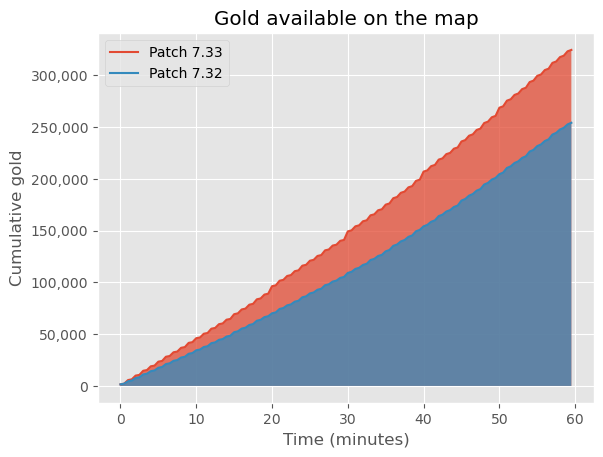

In [16]:
# Gold available on the map
plt.plot(gold_new_df.minute, gold_new_df.cum_total_gold, label = 'Patch 7.33')
plt.fill_between(gold_new_df.minute, gold_new_df.cum_total_gold, alpha = 0.75)

plt.plot(gold_old_df.minute, gold_old_df.cum_total_gold, label = 'Patch 7.32')
plt.fill_between(gold_old_df.minute, gold_old_df.cum_total_gold, alpha = 0.75)

plt.legend(loc = 'upper left')
plt.title('Gold available on the map')
plt.ylabel('Cumulative gold')
plt.xlabel('Time (minutes)')

format_yticks()

plt.show()

Patch 7.33 increased in gold available. If we look at the data as a table:

In [17]:
# Creating a dataframe with the cumulative sum of the total gold from 7.32 and 7.33
gold_comparison = (
    gold_old.merge(gold_new, on = 'minute', how = 'left')
    .loc[:, ['minute', 'cum_total_gold_x', 'cum_total_gold_y']]
    .rename(columns={'cum_total_gold_x': 'old', 'cum_total_gold_y': 'new'})
    )

gold_comparison['%diff'] = (gold_comparison.new / gold_comparison.old - 1) * 100


gold_comparison[(gold_comparison.minute % 10 == 0) & (gold_comparison.minute <= 60)].style.format(
    {'minute': '{:.0f}'.format,
     'old': '{:,.0f}'.format,
     'new': '{:,.0f}'.format,
     '%diff': '{:,.1f}%'.format,}
)

,minute,old,new,%diff
0,0,"1,502","1,502",0.0%
20,10,"34,413","46,094",33.9%
40,20,"70,129","96,314",37.3%
60,30,"109,134","149,276",36.8%
80,40,"154,168","207,006",34.3%
100,50,"204,499","268,724",31.4%
120,60,"259,347","333,927",28.8%


Matches usually don't last longer than an hour, so we can see that the difference in the gold available comparing the two patches is between 29% and 37%.  

#### Cumulative gold by source

It would be good to investigate how much gold different types of sources provide throughout the match.

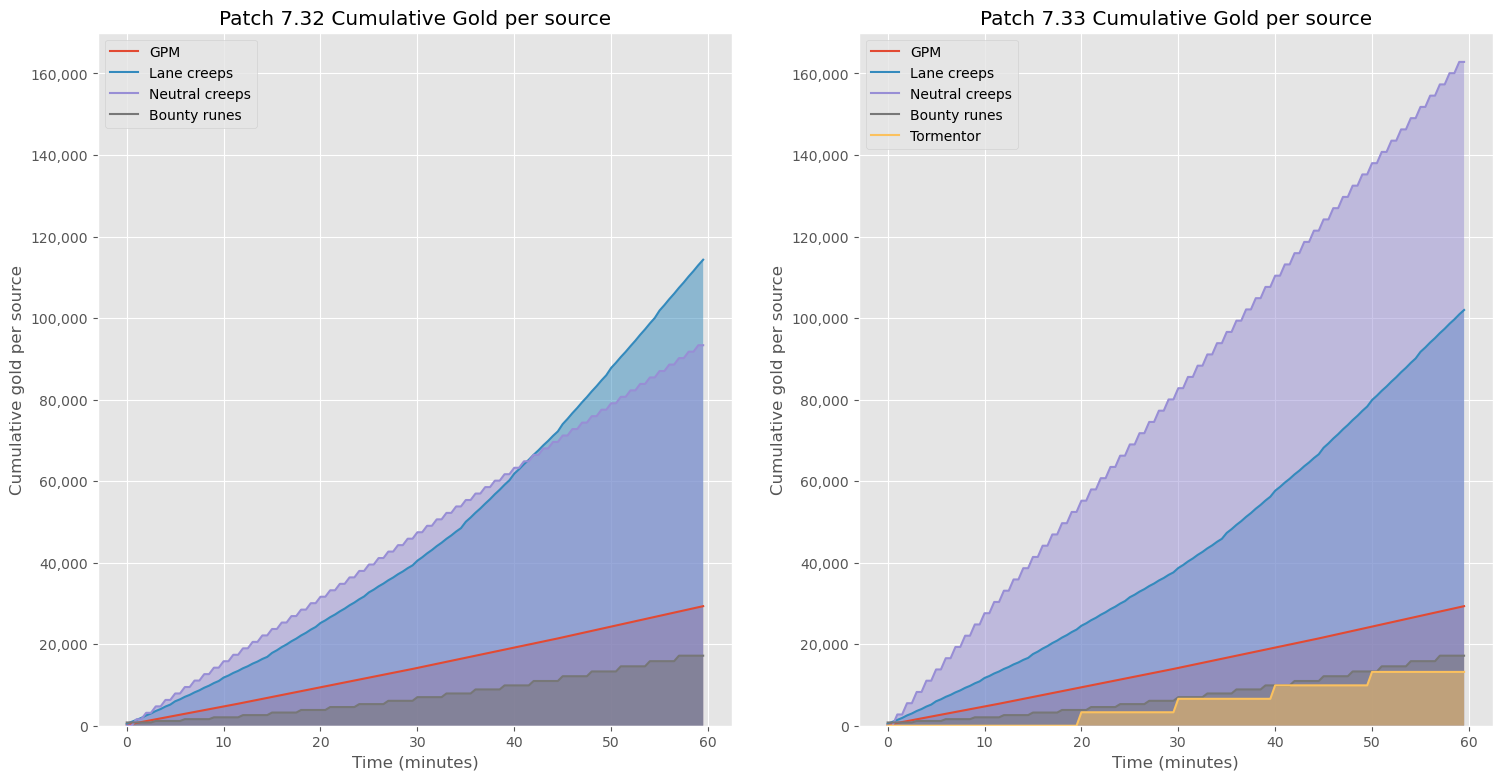

In [18]:
plt.figure(figsize = (18, 9))

# Plot patch 7.32
plt.subplot(1, 2, 1)
plot_dict_old = {'GPM': gold_old_df.cum_periodic_gold, 
           'Lane creeps': gold_old_df.cum_lane_gold,
           'Neutral creeps': gold_old_df.cum_neutrals_gold,
           'Bounty runes': gold_old_df.cum_bounty_gold, }

for label, df in plot_dict_old.items():
    plt.fill_between(gold_old_df.minute, df, alpha = .5)
    plt.plot(gold_old_df.minute, df, label = label, )

plt.legend(loc = 'upper left')
plt.title('Patch 7.32 Cumulative Gold per source')
plt.ylabel('Cumulative gold per source')
plt.xlabel('Time (minutes)')
plt.ylim([0, 170_000])
format_yticks()

# Plot patch 7.33
plt.subplot(1, 2, 2)
plot_dict_new = {'GPM': gold_new_df.cum_periodic_gold, 
           'Lane creeps': gold_new_df.cum_lane_gold,
           'Neutral creeps': gold_new_df.cum_neutrals_gold,
           'Bounty runes': gold_new_df.cum_bounty_gold, 
           'Tormentor': gold_new_df.cum_tormentor_gold}
for label, df in plot_dict_new.items():
    plt.fill_between(gold_new_df.minute, df, alpha = .5)
    plt.plot(gold_new_df.minute, df, label = label, )

plt.legend(loc = 'upper left')
plt.title('Patch 7.33 Cumulative Gold per source')
plt.ylabel('Cumulative gold per source')
plt.xlabel('Time (minutes)')
plt.ylim([0, 170_000])
format_yticks()

plt.show()

As expected, the addition to new jungle camps is one of the most significant changes economy-wise.

Although not as noticeable as the Neutral camps change, the lane creep's reduced upgrade bounties can also be seen through the visualization.

In [19]:
print('Patch 7.32 - Cumulative gold from Lane creeps')
display(
    gold_old.loc[:, ['minute', 'cum_lane_gold']][(gold_old.minute <= 60) & (gold_old.minute % 10 == 0)]
)

print('-'*64)

print('Patch 7.33 - Cumulative gold from Lane creeps')
display(
    gold_new.loc[:, ['minute', 'cum_lane_gold']][(gold_new.minute <= 60) & (gold_new.minute % 10 == 0)]
)

Patch 7.32 - Cumulative gold from Lane creeps


,minute,cum_lane_gold
0,0.0,477.0
20,10.0,11808.0
40,20.0,25200.0
60,30.0,40482.0
80,40.0,61827.0
100,50.0,87771.0
120,60.0,116214.0


----------------------------------------------------------------
Patch 7.33 - Cumulative gold from Lane creeps


,minute,cum_lane_gold
0,0.0,477.0
20,10.0,11709.0
40,20.0,24525.0
60,30.0,38685.0
80,40.0,57645.0
100,50.0,79896.0
120,60.0,103614.0


By the 60:00 minute mark, the difference in gold coming from Lane creeps is roughly a 10% decrease.

#### Gold per minute by source

We can also visualize the gold gained by each minute:

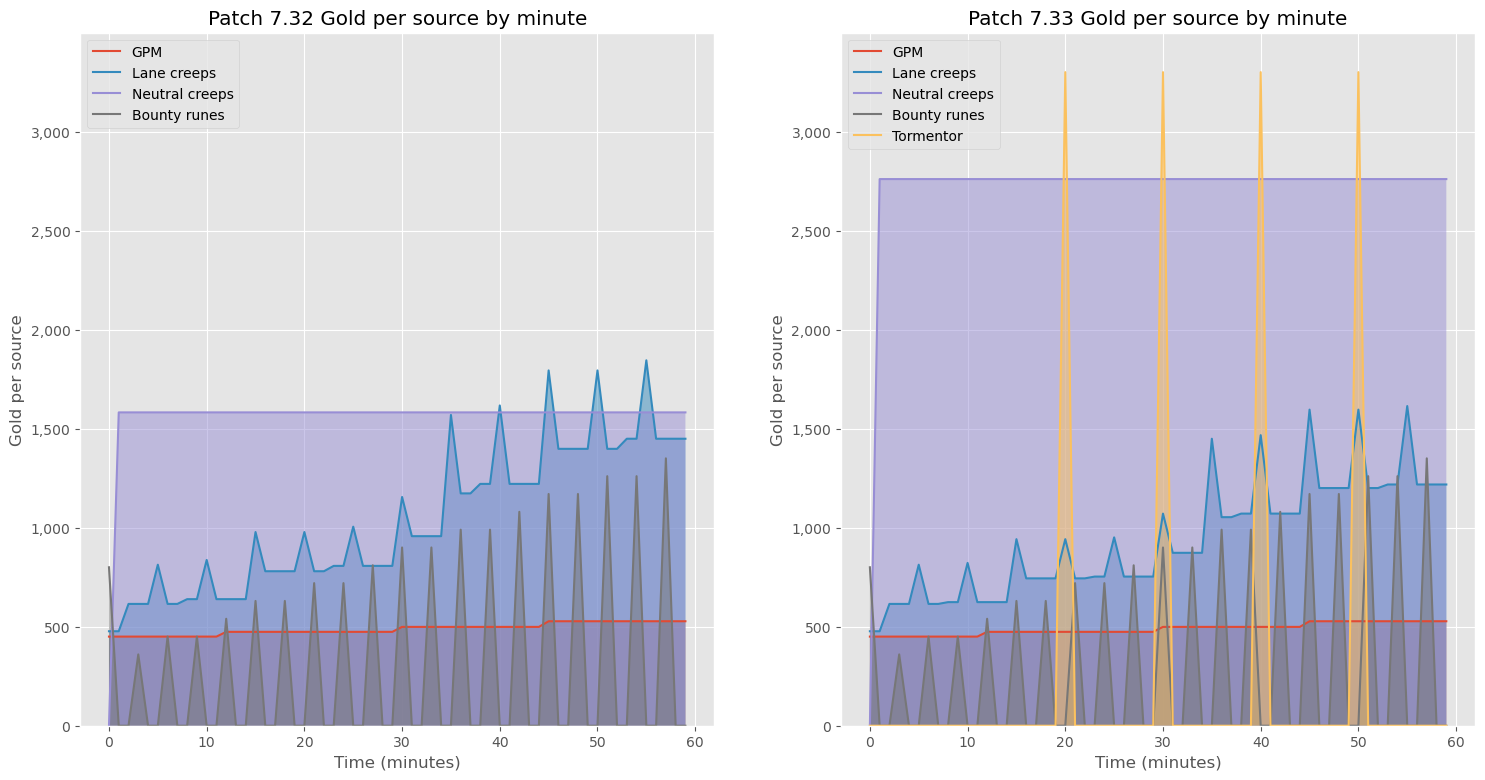

In [20]:
plt.figure(figsize = (18, 9))

# Plot patch 7.32
plt.subplot(1, 2, 1)
gold_old_df_xmin = gold_old_df[gold_old_df.minute % 1 == 0]

plot_dict_old = {'GPM': gold_old_df_xmin.total_periodic_gold * 2, 
           'Lane creeps': gold_old_df_xmin.total_lane_gold,
           'Neutral creeps': gold_old_df_xmin.total_neutrals_gold,
           'Bounty runes': gold_old_df_xmin.total_bounty_gold, }
for label, df in plot_dict_old.items():
    plt.fill_between(gold_old_df_xmin.minute, df, alpha = .5)
    plt.plot(gold_old_df_xmin.minute, df, label = label, )

plt.legend(loc = 'upper left')
plt.title('Patch 7.32 Gold per source by minute')
plt.ylabel('Gold per source')
plt.xlabel('Time (minutes)')
plt.ylim([0, 3_499])
format_yticks()

# Plot patch 7.33
plt.subplot(1, 2, 2)
gold_new_df_xmin = gold_new_df[gold_new_df.minute % 1 == 0]

plot_dict_new = {'GPM': gold_new_df_xmin.total_periodic_gold * 2, 
           'Lane creeps': gold_new_df_xmin.total_lane_gold,
           'Neutral creeps': gold_new_df_xmin.total_neutrals_gold,
           'Bounty runes': gold_new_df_xmin.total_bounty_gold, 
           'Tormentor': gold_new_df_xmin.total_tormentor_gold}
for label, df in plot_dict_new.items():
    plt.fill_between(gold_new_df_xmin.minute, df, alpha = .5)
    plt.plot(gold_new_df_xmin.minute, df, label = label, )

plt.legend(loc = 'upper left')
plt.title('Patch 7.33 Gold per source by minute')
plt.ylabel('Gold per source')
plt.xlabel('Time (minutes)')
plt.ylim([0, 3_499])
format_yticks()

plt.show()


Each minute, the jungle camps are responsible for 2,760 gold, on average, in the new patch. In 7.32, the number was 1,582 gold, an increase of 74.4%.

We can see that Tormentors are actually huge as networth objectives, adding up to 3,300 gold if your team manages to get both of them.

#### Assist gold formula

Let's take a look at the Assist gold change:

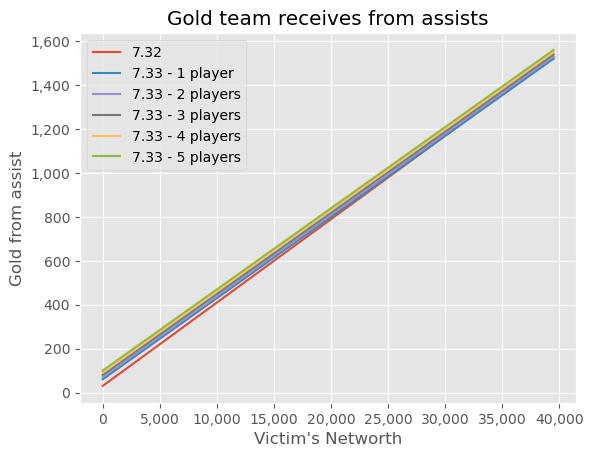

In [21]:
df_columns = {'7.32': 'old', 
              '7.33 - 1 player': 'new_1P', 
              '7.33 - 2 players': 'new_2P', 
              '7.33 - 3 players': 'new_3P', 
              '7.33 - 4 players': 'new_4P', 
              '7.33 - 5 players': 'new_5P'}
for col_label, col in df_columns.items():
    plt.plot(assists.victim_networth, assists.loc[:, col], label = col_label)

plt.legend(loc = 'upper left')
plt.title('Gold team receives from assists')
plt.ylabel('Gold from assist')
plt.xlabel("Victim's Networth")
format_yticks()
format_xticks()
plt.show()

Visually, the gold that a team gains from assisting a kill doesn't seem to have changed so much, especially as the Victim's Networth goes higher. However, if we take a look at the lower portions of Victim's Networth:

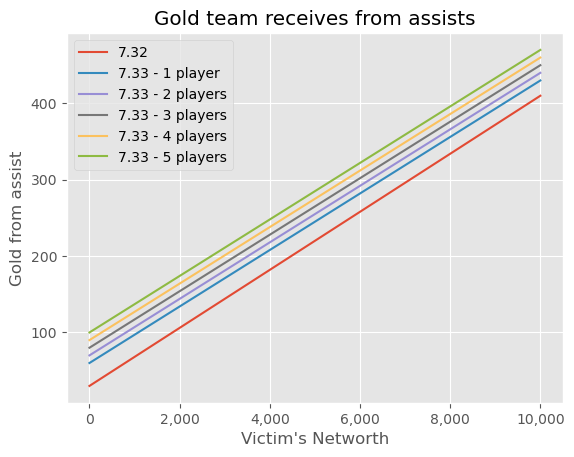

In [22]:
assists_10k_networth = assists[assists.victim_networth <= 10_000]

df_columns = {'7.32': 'old', 
              '7.33 - 1 player': 'new_1P', 
              '7.33 - 2 players': 'new_2P', 
              '7.33 - 3 players': 'new_3P', 
              '7.33 - 4 players': 'new_4P', 
              '7.33 - 5 players': 'new_5P'}
for col_label, col in df_columns.items():
    plt.plot(assists_10k_networth.victim_networth, assists_10k_networth.loc[:, col], label = col_label)

plt.legend(loc = 'upper left')
plt.title('Gold team receives from assists')
plt.ylabel('Gold from assist')
plt.xlabel("Victim's Networth")
format_yticks()
format_xticks()
plt.show()

In [23]:
assists.head(21)

,victim_networth,old,new_1P,new_2P,new_3P,new_4P,new_5P
0,0,30.0,60.0,70.0,80.0,90.0,100.0
1,500,49.0,78.5,88.5,98.5,108.5,118.5
2,1000,68.0,97.0,107.0,117.0,127.0,137.0
3,1500,87.0,115.5,125.5,135.5,145.5,155.5
4,2000,106.0,134.0,144.0,154.0,164.0,174.0
5,2500,125.0,152.5,162.5,172.5,182.5,192.5
6,3000,144.0,171.0,181.0,191.0,201.0,211.0
7,3500,163.0,189.5,199.5,209.5,219.5,229.5
8,4000,182.0,208.0,218.0,228.0,238.0,248.0
9,4500,201.0,226.5,236.5,246.5,256.5,266.5


We can see that the difference in assist gold is higher, percentage-wise, when the Victim's Networth is lower. 

Also we can see that there is an increase in gold gained the more heroes there are to participate in the kills.

## Closing Thoughts

The game deffinetly has more gold available to the players, which would usually imply in a more "farm-oriented" gameplay.

Considering the farm available comes largely from an increase in neutral camps, and with the map also increasing in size, it will be harder for teams to efficiently capitalize on all of the available resources. In this context, it seems reasonable that players will be split-pushing more often in this patch.

On the other hand, the changes to the Assist formula, the increased night movement speed of heroes, the new Twin Gates and the amount of mini-objectives (watchers, bounties, lotus, water/power runes, wisdom runes), all add up to a heavy brawling and skirmish-oriented meta, which will severely punish players that are split-pushing alone while not being aware of enemies' position.

## Bonus!

Here are some visualizations of the gold given by neutrals and lane creeps (at the very start of the game). Knowing how much each camp provides can help you planning your farm route.

![](images/map_gold_1.PNG)


From the average numbers, one ancient camp is roughly equal to two medium camps, while one large camp is similar to two easy camps.

![](images/map_gold_2.PNG)

From the image above, one can see that farming the triangle provides as much gold as farming the 5 camps in Radiant's bottom / Dire's top portions of the map. The main original jungles provide approximately 100 additional gold, which is pretty much the difference from having one more hard camp than other regions.